In [1]:
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import warnings

import condo

In [2]:
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['axes.linewidth'] = 0.5
plt.rc('font', size=7) #controls default text size
plt.rc('axes', titlesize=7) #fontsize of the title
plt.rc('axes', labelsize=7) #fontsize of the x and y labels
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.rc('legend', fontsize=7) #fontsize of the legend
plt.ioff();

In [3]:
N_T = 200
N_S = 100
mmd_size = 20

# How batch effect affects S
batch_m = 2
batch_b = 5

# The true batch correction from Sbatch to S
true_m = 1. / batch_m
true_b = -1 * batch_b / batch_m

noise_settings = ["NoiseFree"]
targetshift_settings = ["TargetShift"]
featureshift_settings = ["FeatureShift"]
multivar_settings = ["1", "2", "4", "8", "16", "32"]

prob_settings = ["Homoscedastic Linear", "Heteroscedastic Linear", "Nonlinear"]
num_probs = len(prob_settings)

# method -> (num_Ns, num_random) array
rMSEs = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
rMSEs_test = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
num_random = 10
for rix in range(num_random):
    rng = np.random.RandomState(rix)
    for setting_combo in product(noise_settings, targetshift_settings, featureshift_settings, multivar_settings):
        (noise_setting, targetshift_setting, featureshift_setting, multivar_setting) = setting_combo
        setting_str = "-".join(setting_combo)
        assert noise_setting in ("Noisy", "NoiseFree")
        assert targetshift_setting in ("NoTargetShift", "TargetShift")
        assert featureshift_setting in ("NoFeatureShift", "FeatureShift")
        num_dummy = int(multivar_setting) - 1

        fig, axes = plt.subplots(
            nrows=7, ncols=num_probs, sharex="all", sharey="all", squeeze=False,
            gridspec_kw={"hspace": 0.03, "wspace": 0.03},
            figsize=(6, 10), dpi=150)
        msize = 1
        basic_leg = ['target', 'source: batch-effected', 'source: true (unobserved)']
        figname = f"figure-continuous1d-dummy-{setting_str}-{rix}.pdf"
        fsizemse = 7

        for pix, prob_setting in enumerate(prob_settings):
            print(f"rix:{rix} {setting_str} {prob_setting}")
            # Distribution of confounders
            X_T = np.sort(rng.uniform(0, 8, size=(N_T,)))
            if targetshift_setting == "TargetShift":
                X_S = np.sort(rng.uniform(4, 8, size=(N_S,)))
                X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))
            elif targetshift_setting == "NoTargetShift":
                X_S = np.sort(rng.uniform(0, 8, size=(N_S,)))
                X_S_test = np.sort(rng.uniform(0, 8, size=(N_S,)))
            X_T_dummy = rng.normal(size=(N_T, num_dummy))
            X_S_dummy = rng.normal(size=(N_S, num_dummy))
            
            if prob_setting == "Homoscedastic Linear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 0
                phi_b = 2
                mu_T = theta_m * X_T + theta_b
                mu_S = theta_m * X_S + theta_b
                mu_S_test = theta_m * X_S_test + theta_b
                sigma_T = phi_m * X_T + phi_b
                sigma_S = phi_m * X_S + phi_b
                sigma_S_test = phi_m * X_S_test + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            elif prob_setting == "Heteroscedastic Linear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 1
                phi_b = 1
                mu_T = theta_m * X_T + theta_b
                mu_S = theta_m * X_S + theta_b
                mu_S_test = theta_m * X_S_test + theta_b
                sigma_T = phi_m * X_T + phi_b
                sigma_S = phi_m * X_S + phi_b
                sigma_S_test = phi_m * X_S_test + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            elif prob_setting == "Nonlinear":
                # How confounder X affects the distribution of T and S
                theta_m = 4
                theta_b = 1
                phi_m = 1
                phi_b = 1
                mu_T = theta_m * (np.maximum(X_T-5, 0) ** 2) + theta_b
                mu_S = theta_m * (np.maximum(X_S-5, 0) ** 2) + theta_b
                mu_S_test = theta_m * (np.maximum(X_S_test-5, 0) ** 2) + theta_b
                sigma_T = phi_m * (np.maximum(X_T-5, 0) ** 2) + phi_b
                sigma_S = phi_m * (np.maximum(X_S-5, 0) ** 2) + phi_b
                sigma_S_test = phi_m * (np.maximum(X_S_test-5, 0) ** 2) + phi_b
                T = rng.normal(mu_T, sigma_T)
                Strue = rng.normal(mu_S, sigma_S)
                Strue_test = rng.normal(mu_S_test, sigma_S_test)
            if featureshift_setting == "FeatureShift":
                Sbatch = batch_m * Strue + batch_b
                Sbatch_test = batch_m * Strue_test + batch_b
                oracle_m = true_m
                oracle_b = true_b
            elif featureshift_setting == "NoFeatureShift":
                oracle_m = 1.0
                oracle_b = 0.0
                Sbatch = Strue.copy()
                Sbatch_test = Strue_test.copy()

            if noise_setting == "NoiseFree":
                pass
            elif noise_setting == "Noisy":
                Sbatch = Sbatch + rng.normal(0, 1, size=(N_S,))
                Sbatch_test = Sbatch_test + rng.normal(0, 1, size=(N_S,))

            T_ = T.reshape(-1, 1) # (N_T, 1)
            Strue_ = Strue.reshape(-1, 1) # (N_S, 1)
            Sbatch_ = Sbatch.reshape(-1, 1)
            X_T_ = X_T.reshape(-1, 1) # (N_T, 1)
            X_S_ = X_S.reshape(-1, 1)
            Strue_test_ = Strue_test.reshape(-1, 1) # (N_S, 1)
            Sbatch_test_ = Sbatch_test.reshape(-1, 1)
            X_S_test_ = X_S_test.reshape(-1, 1)
            
            # Before correction
            method = "batch-effected"
            rMSE = np.sqrt(np.mean((Sbatch - Strue) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sbatch_test - Strue_test) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[0, pix].tick_params(axis="both", which="both", direction="in")    
            axes[0, pix].scatter(X_T, T, s=msize)
            axes[0, pix].scatter(X_S, Sbatch, s=msize)
            axes[0, pix].scatter(X_S, Strue, s=msize)
            axes[0, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[0, pix].transAxes);
            if pix == num_probs - 1:
                axes[0, pix].legend(
                    basic_leg,
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # Oracle - not displayed
            method = "Oracle"
            Soracle = oracle_m * Sbatch + oracle_b
            Soracle_test = oracle_m * Sbatch_test + oracle_b
            rMSE = np.sqrt(np.mean((Soracle - Strue) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Soracle_test - Strue_test) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")

            # OTDA
            method = "Gaussian OT"
            lter = condo.AdapterGaussianOT()
            lter.fit(Xs=Sbatch_, Xt=T_)
            Sotda_ = lter.transform(Xs=Sbatch_)
            Sotda_test_ = lter.transform(Xs=Sbatch_test_)
            rMSE = np.sqrt(np.mean((Sotda_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sotda_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[1, pix].tick_params(axis="both", which="both", direction="in")    
            axes[1, pix].scatter(X_T, T, s=msize)
            axes[1, pix].scatter(X_S, Sbatch, s=msize)
            axes[1, pix].scatter(X_S, Strue, s=msize)
            axes[1, pix].scatter(X_S, Sotda_, s=msize)
            axes[1, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[1, pix].transAxes);
            if pix == num_probs - 1:
                axes[1, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # MMD
            method = "MMD"
            mmd_alpha = 0.01
            if prob_setting == "Nonlinear":
                mmd_alpha = 0.01
            cder = condo.AdapterMMD(
                transform_type="location-scale",
                n_epochs=100,
                learning_rate=1e-2,
                mmd_size=mmd_size,
            )
            cder.fit(Sbatch_, T_)
            Smmd_ = cder.transform(Sbatch_)
            Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[2, pix].tick_params(axis="both", which="both", direction="in")    
            axes[2, pix].scatter(X_T, T, s=msize)
            axes[2, pix].scatter(X_S, Sbatch, s=msize)
            axes[2, pix].scatter(X_S, Strue, s=msize)
            axes[2, pix].scatter(X_S, Smmd_, s=msize)
            axes[2, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[2, pix].transAxes);
            if pix == num_probs - 1:
                axes[2, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);

            # ConDo using ReverseKL with linear Gaussian
            method = "ConDo Gaussian KLD"
            cder = condo.ConDoAdapterKLD(
                transform_type="location-scale",
                verbose=0,
            )
            cder.fit(Sbatch_, T_, np.hstack([X_S_, X_S_dummy]), np.hstack([X_T_, X_T_dummy]))
            Sreverse_ = cder.transform(Sbatch_)
            Sreverse_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Sreverse_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Sreverse_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting])
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[3, pix].tick_params(axis="both", which="both", direction="in")    
            axes[3, pix].scatter(X_T, T, s=msize)
            axes[3, pix].scatter(X_S, Sbatch, s=msize)
            axes[3, pix].scatter(X_S, Strue, s=msize)
            axes[3, pix].scatter(X_S, Sreverse_, s=msize)
            axes[3, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f} ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[3, pix].transAxes);
            if pix == num_probs - 1:
                axes[3, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);            

            # Condo using MMD
            method = "ConDo MMD"
            cder = condo.ConDoAdapterMMD(
                transform_type="location-scale",
                n_epochs=100,
                learning_rate=1e-2,
                mmd_size=mmd_size,
            )
            cder.fit(Sbatch_, T_, np.hstack([X_S_, X_S_dummy]), np.hstack([X_T_, X_T_dummy]))
            Smmd_ = cder.transform(Sbatch_)
            Smmd_test_ = cder.transform(Sbatch_test_)
            rMSE = np.sqrt(np.mean((Smmd_ - Strue_) ** 2));
            rMSEs[setting_str][method][prob_setting].append(rMSE)
            rMSE_test = np.sqrt(np.mean((Smmd_test_ - Strue_test_) ** 2));
            rMSEs_test[setting_str][method][prob_setting].append(rMSE_test)
            avgrMSE = np.mean(rMSEs[setting_str][method][prob_setting])
            avgrMSE_test = np.mean(rMSEs_test[setting_str][method][prob_setting]);
            print(f"    {method} rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})")
            axes[4, pix].tick_params(axis="both", which="both", direction="in")    
            axes[4, pix].scatter(X_T, T, s=msize)
            axes[4, pix].scatter(X_S, Sbatch, s=msize)
            axes[4, pix].scatter(X_S, Strue, s=msize)
            axes[4, pix].scatter(X_S, Smmd_, s=msize)
            axes[4, pix].text(
                0.1, 0.9, f"rMSE: {avgrMSE:.3f}  ({avgrMSE_test:.3f})", size=fsizemse,
                transform = axes[4, pix].transAxes);
            if pix == num_probs - 1:
                axes[4, pix].legend(
                    basic_leg + [f"source: {method}"],
                    loc="center left", bbox_to_anchor=(1.05, 0.5),
                    frameon=False, borderpad=0.2, handlelength=0.3, borderaxespad=0.2);
        #if rix in (0, num_random - 1):
        #    fig.savefig(figname, bbox_inches="tight")
        plt.close()

rix:0 NoiseFree-TargetShift-FeatureShift-1 Homoscedastic Linear
    batch-effected rMSE: 30.110  (22.992)
    Oracle rMSE: 0.000  (0.000)
    Gaussian OT rMSE: 9.049  (17.721)
n_batches: 13 dataset_size:(100, 20, 1)
MMD sample shapes torch.Size([8, 20, 1]) torch.Size([8, 20, 1])
    MMD rMSE: 5.017  (4.897)
    ConDo Gaussian KLD rMSE: 0.459  (1.218)
n_batches: 13 dataset_size:(100, 20, 1)
MMD sample shapes torch.Size([8, 20, 1]) torch.Size([8, 20, 1])
    ConDo MMD rMSE: 0.459  (1.016)
rix:0 NoiseFree-TargetShift-FeatureShift-1 Heteroscedastic Linear
    batch-effected rMSE: 31.425  (26.066)
    Oracle rMSE: 0.000  (0.000)
    Gaussian OT rMSE: 8.538  (11.201)
n_batches: 13 dataset_size:(100, 20, 1)
MMD sample shapes torch.Size([8, 20, 1]) torch.Size([8, 20, 1])
    MMD rMSE: 7.915  (7.338)
    ConDo Gaussian KLD rMSE: 0.873  (1.374)
n_batches: 13 dataset_size:(100, 20, 1)
MMD sample shapes torch.Size([8, 20, 1]) torch.Size([8, 20, 1])
    ConDo MMD rMSE: 1.763  (1.840)
rix:0 NoiseFre

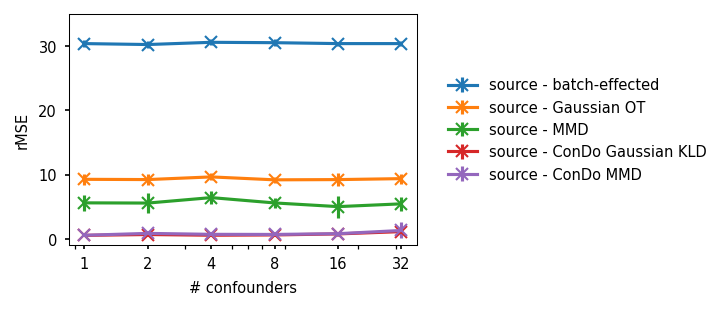

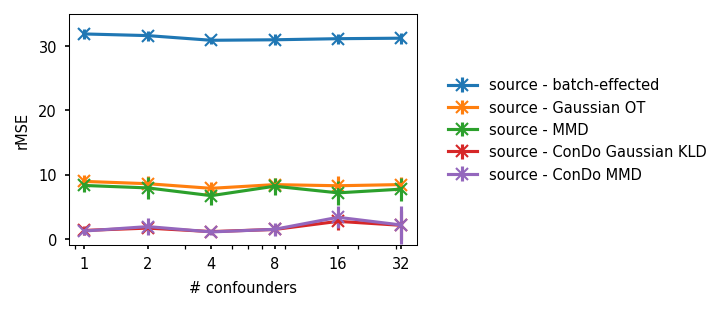

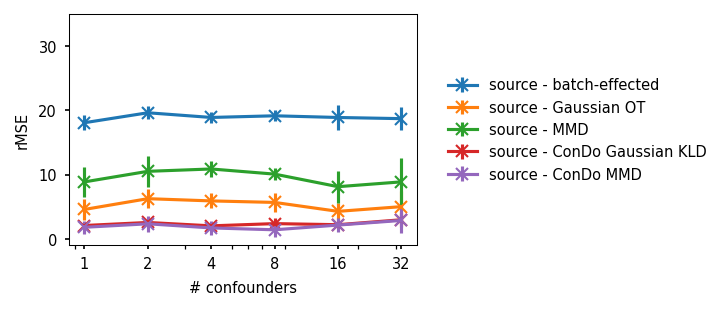

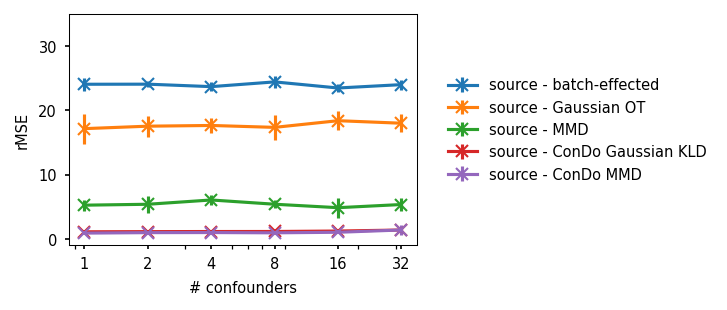

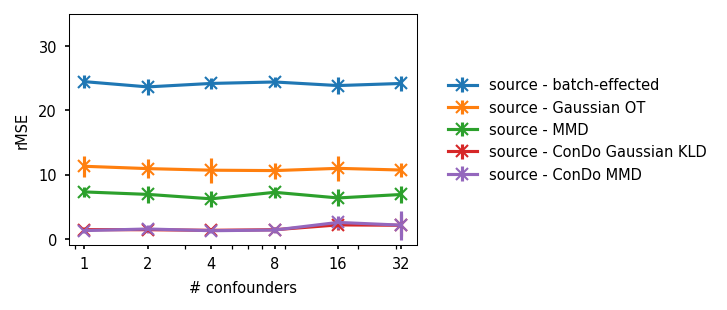

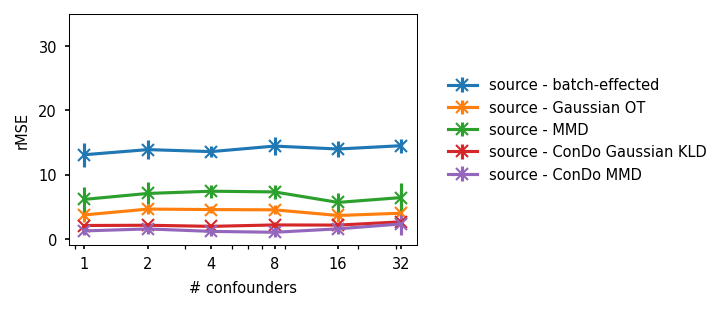

In [4]:
methods = [
    "true (unobserved)",
    "batch-effected",
    "Gaussian OT",
    "MMD",
    "ConDo Gaussian KLD", 
    "ConDo MMD",
]
print_methods = [f"source - {meth}" for meth in methods]
num_multivars = len(multivar_settings)
multivars_np = np.array([int(mv) for mv in multivar_settings])
for prob_setting in prob_settings:
    fig = plt.figure(dpi=150, figsize=(3, 2))
    #for _ in range(2):
    #    # skip target, source-true
    #    next(plt.gca()._get_lines.prop_cycler)

    # skip true (always 0)
    for method in methods[1:]:
        # generate np.array of size (num_multivars, num_random)
        plot_rmses = -1 * np.ones((num_multivars, num_random))
        for mvix, mv_setting in enumerate(multivar_settings):
            sstr = f"{noise_setting}-{targetshift_setting}-{featureshift_setting}-{mv_setting}"
            for rix in range(num_random):
                plot_rmses[mvix, :] = np.array(rMSEs[sstr][method][prob_setting])
        plt.errorbar(
            multivars_np,
            np.mean(plot_rmses, axis=1),
            yerr=np.minimum(35, np.std(plot_rmses, axis=1)), marker='x');
    plt.ylabel('rMSE');
    plt.xlabel('# confounders');
    plt.xscale('log');
    plt.xticks([int(mv) for mv in multivar_settings], multivar_settings);
    plt.legend(
        print_methods[1:],
        title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    );
    plt.gca().set_ylim(-1, 35);
    figname = f"figure-continuous1d-dummy-{prob_setting}-rmses-{num_random}.pdf"
    fig.savefig(figname, bbox_inches="tight")
for prob_setting in prob_settings:
    fig = plt.figure(dpi=150, figsize=(3, 2))
    #for _ in range(2):
    #    # skip target, source-true
    #    next(plt.gca()._get_lines.prop_cycler)

    # skip true (always 0)
    for method in methods[1:]:
        # generate np.array of size (num_multivars, num_random)
        plot_rmses = -1 * np.ones((num_multivars, num_random))
        for mvix, mv_setting in enumerate(multivar_settings):
            sstr = f"{noise_setting}-{targetshift_setting}-{featureshift_setting}-{mv_setting}"
            for rix in range(num_random):
                plot_rmses[mvix, :] = np.array(rMSEs_test[sstr][method][prob_setting])
        plt.errorbar(
            multivars_np,
            np.mean(plot_rmses, axis=1),
            yerr=np.minimum(35, np.std(plot_rmses, axis=1)), marker='x');
    plt.ylabel('rMSE');
    plt.xlabel('# confounders');
    plt.xscale('log');
    plt.xticks([int(mv) for mv in multivar_settings], multivar_settings);
    plt.legend(
        print_methods[1:],
        title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    );
    plt.gca().set_ylim(-1, 35);
    figname = f"figure-continuous1d-dummy-{prob_setting}-rmsestest-{num_random}.pdf"
    #fig.savefig(figname, bbox_inches="tight")


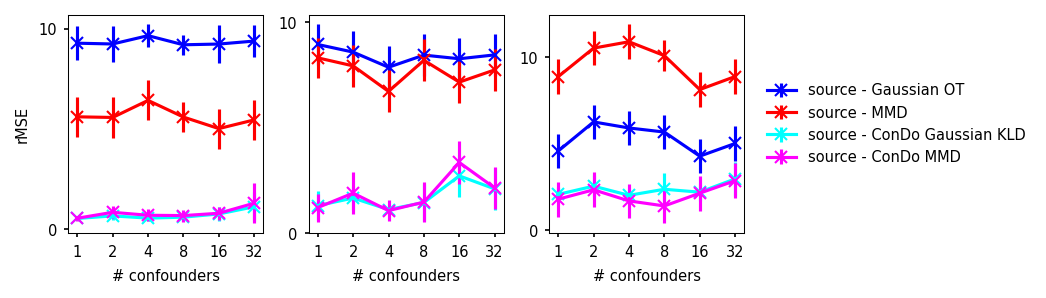

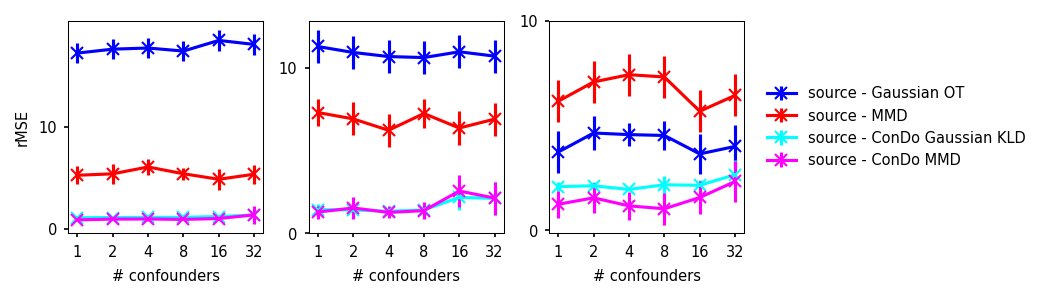

In [7]:
methods = [
    "true (unobserved)",
    "batch-effected",
    "Gaussian OT",
    "MMD",
    "ConDo Gaussian KLD", 
    "ConDo MMD",
]
mcolors = ["blue", "red", "cyan", "magenta"]
print_methods = [f"source - {meth}" for meth in methods]
num_multivars = len(multivar_settings)
multivars_np = np.array([int(mv) for mv in multivar_settings])
fig, axes = plt.subplots(
    dpi=150, nrows=1, ncols=len(prob_settings), figsize=(7, 2), sharey=False)
for probix, prob_setting in enumerate(prob_settings):
    for mix, method, mcolor in zip(range(len(mcolors)), methods[2:], mcolors):
        # generate np.array of size (num_multivars, num_random)
        plot_rmses = -1 * np.ones((num_multivars, num_random))
        for mvix, mv_setting in enumerate(multivar_settings):
            sstr = f"{noise_setting}-{targetshift_setting}-{featureshift_setting}-{mv_setting}"
            for rix in range(num_random):
                plot_rmses[mvix, :] = np.array(rMSEs[sstr][method][prob_setting])
        axes[probix].errorbar(
            multivars_np,
            np.mean(plot_rmses, axis=1),
            yerr=np.minimum(1, np.std(plot_rmses, axis=1)),
            marker='x', color=mcolor);
    if probix == 0:
        axes[probix].set_ylabel('rMSE');
    axes[probix].set_xlabel('# confounders');
    axes[probix].set_xscale('log');
    axes[probix].set_xticks([int(mv) for mv in multivar_settings], multivar_settings);
    axes[probix].set_yticks([0, 10]);
    axes[probix].minorticks_off()
plt.legend(
    print_methods[2:],
    title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False,
);
plt.tight_layout();
figname = f"figure-continuous1d-dummy-rmses-{num_random}.pdf"
fig.savefig(figname, bbox_inches="tight")

fig, axes = plt.subplots(
    dpi=150, nrows=1, ncols=len(prob_settings), figsize=(7, 2), sharey=False)
for probix, prob_setting in enumerate(prob_settings):
    for mix, method, mcolor in zip(range(len(mcolors)), methods[2:], mcolors):
        # generate np.array of size (num_multivars, num_random)
        plot_rmses = -1 * np.ones((num_multivars, num_random))
        for mvix, mv_setting in enumerate(multivar_settings):
            sstr = f"{noise_setting}-{targetshift_setting}-{featureshift_setting}-{mv_setting}"
            for rix in range(num_random):
                plot_rmses[mvix, :] = np.array(rMSEs_test[sstr][method][prob_setting])
        axes[probix].errorbar(
            multivars_np,
            np.mean(plot_rmses, axis=1),
            yerr=np.minimum(1, np.std(plot_rmses, axis=1)),
            marker='x', color=mcolor);
    if probix == 0:
        axes[probix].set_ylabel('rMSE');
    axes[probix].set_xlabel('# confounders');
    axes[probix].set_xscale('log');
    axes[probix].set_xticks([int(mv) for mv in multivar_settings], multivar_settings);
    axes[probix].set_yticks([0, 10]);
    axes[probix].minorticks_off()
plt.legend(
    print_methods[2:],
    title='', loc="center left", bbox_to_anchor=(1.05, 0.5),
    frameon=False,
);
plt.tight_layout();
figname = f"figure-continuous1d-dummy-rmsestest-{num_random}.pdf"
fig.savefig(figname, bbox_inches="tight")